# Module 2 Final Project
### Rich Caputo

In this notebook, we will examine the Northwind database and attempt to answer the question:

**Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?** In addition to three other questions which we will address later on.

For reference, we have included the ERD below:
<img src='Northwind_ERD.png'>

As a first order of business, let's load the database into python using SQLAlchemy.

In [1]:
# Get relevant packages
import pandas as pd
from sqlalchemy import *
from sqlalchemy.ext.automap import automap_base
import numpy as np 
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
# Connect with sqlalchemy
engine = create_engine('sqlite:///Northwind_small.sqlite')
conn = engine.connect()

In [3]:
# Get each table name
pprint(engine.table_names())

['Category',
 'Customer',
 'CustomerCustomerDemo',
 'CustomerDemographic',
 'Employee',
 'EmployeeTerritory',
 'Order',
 'OrderDetail',
 'Product',
 'Region',
 'Shipper',
 'Supplier',
 'Territory']


We now have access to our database directly. Notice that some tables have slightly different names than what they are labeled as in the ERD - it is always good practice to print table names. In order to answer our first question, we are primarily focused on looking at the following tables:
- OrderDetail
- Product

We need to take a look at the number of orders per product and differentiate between non-discounted and discounted products. The following query should contain all of the data we need for statistical analysis. Let's run this query and import our data into a pandas DataFrame.

In [4]:
# Inspect column names - ensures correct queries
inspector = inspect(engine)
print([x['name'] for x in inspector.get_columns('OrderDetail')])
print([x['name'] for x in inspector.get_columns('Product')])

['Id', 'OrderId', 'ProductId', 'UnitPrice', 'Quantity', 'Discount']
['Id', 'ProductName', 'SupplierId', 'CategoryId', 'QuantityPerUnit', 'UnitPrice', 'UnitsInStock', 'UnitsOnOrder', 'ReorderLevel', 'Discontinued']


In [5]:
# Query relevant columns
query = """
SELECT 
    p.ProductName, od.UnitPrice, od.Quantity, od.Discount
FROM 
    Product p
    JOIN
    OrderDetail od
    ON 
    p.Id = od.ProductId
"""
df = pd.read_sql_query(query, engine)

In [6]:
df.head()

,ProductName,UnitPrice,Quantity,Discount
0,Queso Cabrales,14.0,12,0.0
1,Singaporean Hokkien Fried Mee,9.8,10,0.0
2,Mozzarella di Giovanni,34.8,5,0.0
3,Tofu,18.6,9,0.0
4,Manjimup Dried Apples,42.4,40,0.0


In [7]:
# Check number of unique products
df.ProductName.nunique()

77

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 4 columns):
ProductName    2155 non-null object
UnitPrice      2155 non-null float64
Quantity       2155 non-null int64
Discount       2155 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 67.4+ KB


Great! We have all the data we need currently but can always run a new query to get more data if we need it. Let's now get to our hypothesis testing. Our hypothesis is that discounts have no effect on the number of products customers order. Our data currently contains each order along with: 
- Name of product being ordered
- Unit price of that product
- Quantity of product being ordered
- Percentage discount on that order

We need to differentiate between discounted and non-discounted orders. We can do this easily with pandas slicing. We will then take a look at each populations sample statistics.

In [9]:
df_disc, df_ndisc = df.loc[df.Discount > 0], df.loc[df.Discount == 0]

In [10]:
# Discounted Statistics
df_disc.describe()

,UnitPrice,Quantity,Discount
count,838.000000,838.000000,838.000000
mean,26.292363,27.109785,0.144439
std,30.017214,20.771439,0.071808
min,2.000000,1.000000,0.010000
25%,12.500000,12.000000,0.100000
50%,18.000000,20.000000,0.150000
75%,31.230000,36.000000,0.200000
max,263.500000,130.000000,0.250000


In [11]:
# Non-discounted Statistics
df_ndisc.describe()

,UnitPrice,Quantity,Discount
count,1317.000000,1317.000000,1317.0
mean,26.171534,21.715262,0.0
std,29.717354,17.507493,0.0
min,2.000000,1.000000,0.0
25%,12.000000,10.000000,0.0
50%,18.400000,18.000000,0.0
75%,32.800000,30.000000,0.0
max,263.500000,130.000000,0.0


We see that discounted orders have a higher Quantity mean. However, this is not enough information to lead us to reject the null hypothesis. To get a better sense of Quantity distribution, we will extrapolate the PDF's of each population and plot them.

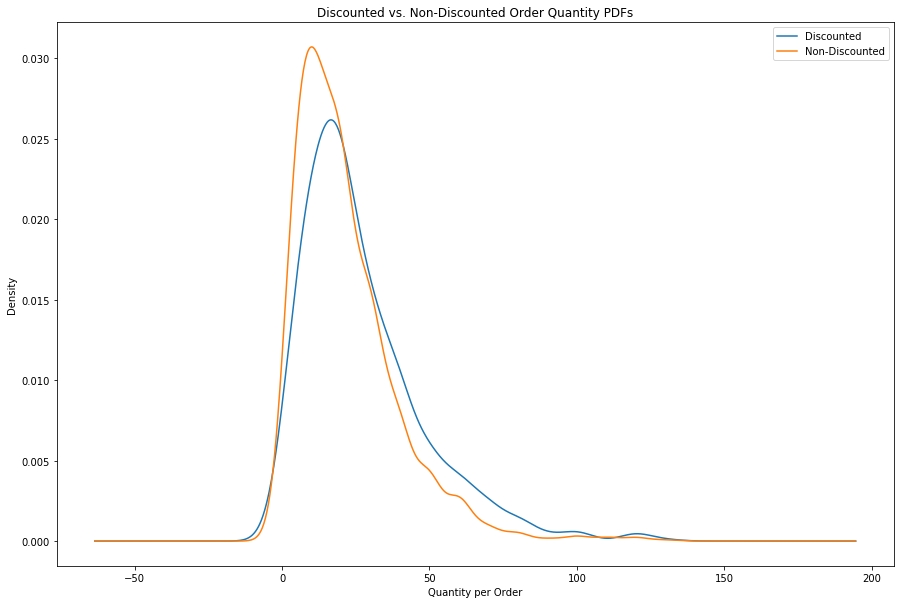

In [12]:
# Plotting
plt.figure(figsize=(15, 10))
df_disc.Quantity.plot.kde(label='Discounted')
df_ndisc.Quantity.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Quantity PDFs')
plt.xlabel('Quantity per Order')
plt.legend()
plt.show()

It's beginning to look like discounted orders have a slightly different distribution than non-discounted orders. We still need to validate this, so let's formerly phrase our hypothesis test. Let A represent the Quantity population of discounted orders and let B represent the Quantity population of non-discounted orders. 

Null Hypothesis ($H_0$):

$$\mu_A = \mu_B$$

Alternative Hypothesis ($H_1$):

$$\mu_A > \mu_B$$

where $\mu_i$ represents the mean of population i. Notice that this represents a one-sided test since we only care if discounts increase order quantity. To implement our hypothesis test, we will use scipy's ttest_ind function and divide our alpha value by two. We will assume that discounted orders and non-discounted orders are independent samples. Furthermore, we will note that these distributions have unequal variance as this will affect our hypothesis test.

In [13]:
import scipy.stats as stats

# Get two-sample ttest
results = stats.ttest_ind(df_disc.Quantity, df_ndisc.Quantity, equal_var=False)

# pvalue <<< 0.05 reject null hypothesis, quantity mean of Discounted is greater than that of Non-discounted
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted")
else:
    print("Accept null hypothesis")

Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted


Looks like we have a statistically significant difference in population means. Let's see what our t-statistic and p-value actually were.

In [14]:
results

Ttest_indResult(statistic=6.239069142123973, pvalue=5.65641429030433e-10)

Our p-value is very small and our t-statistic is very high - we can affirm with high confidence that these population means are not equal and that in fact discounted orders are on average larger in quantity. Recall that we separated populations based on any discount >0 being different from any order with discount=0.

Let's now consider the monetary affect of discounts. Instead of just looking at quantity, we will generate a new column called 'Revenue' such that 
$$ Revenue = Quantity * Unit Price * (1 - Discount) $$
and perform a t-test using this new metric. This will tell us if Discounts are financially an advantageous strategy. First we will consider a >0 / =0 split as before and then look at different discount thresholds.

In [16]:
df_disc['Revenue'] = df_disc.Quantity * df_disc.UnitPrice * (1 - df_disc.Discount)
df_ndisc['Revenue'] = df_ndisc.Quantity * df_ndisc.UnitPrice * (1 - df_ndisc.Discount)

C:\Users\caputr\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\caputr\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


We will now look at the sample statistics of these distributions and plot their KDE's. From there we will perform a similar t-test as before!

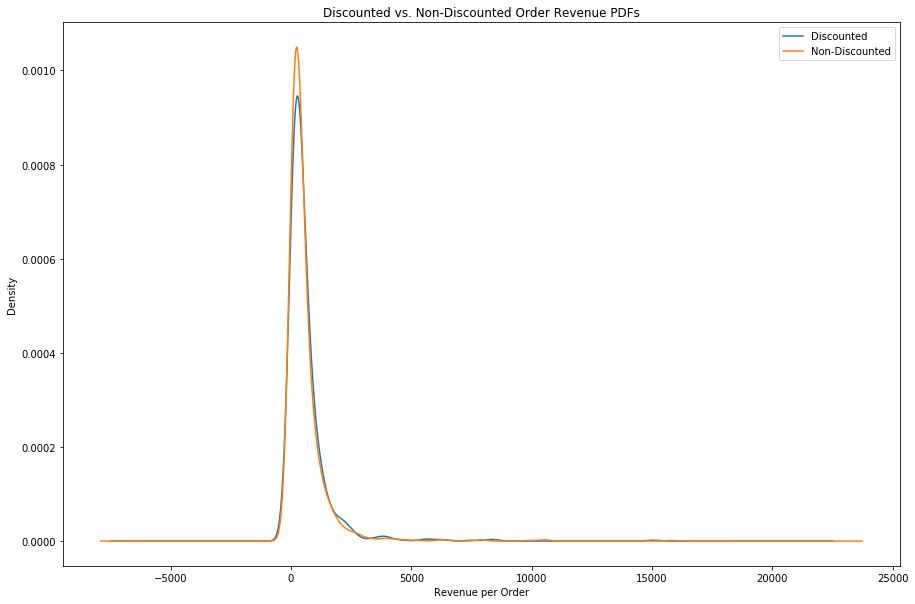

In [17]:
# Plotting
plt.figure(figsize=(15, 10))
df_disc.Revenue.plot.kde(label='Discounted')
df_ndisc.Revenue.plot.kde(label='Non-Discounted')
plt.title('Discounted vs. Non-Discounted Order Revenue PDFs')
plt.xlabel('Revenue per Order')
plt.legend()
plt.show()

Due to the large tails of the Revenue distribution, it is difficult to gain any insight from the above plot. Let's look at the sample statistics of each distribution.

In [18]:
df_disc.Revenue.describe()

count      838.000000
mean       614.671157
std        981.388386
min          8.500000
25%        162.000000
50%        347.775000
75%        693.600000
max      15019.500000
Name: Revenue, dtype: float64

In [19]:
df_ndisc.Revenue.describe()

count     1317.000000
mean       570.006538
std        961.375030
min          4.800000
25%        142.500000
50%        325.000000
75%        640.000000
max      15810.000000
Name: Revenue, dtype: float64

It seems that revenue is larger for discounted orders on average. Let's finally perform a one-sided t-test to confirm if this difference is statistically significant.

In [20]:
# Get two-sample ttest
results = stats.ttest_ind(df_disc.Revenue, df_ndisc.Revenue, equal_var=False)

# pvalue <<< 0.05 reject null hypothesis, quantity mean of Discounted is greater than that of Non-discounted
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted")
else:
    print("Accept null hypothesis")

Accept null hypothesis


It seems that this difference is not statistically significant at the 0.05 level. Let's take a look at our results.

In [21]:
results

Ttest_indResult(statistic=1.0381255545690475, pvalue=0.2993546075168257)

In fact, our results have quite a high p-value. It seems that although discounts provide a statistically significant affect on order quantity, they do not have a statistically significant affect on Revenue. Let's see if discount size has any affect. First, we will examine revenue as a function of discount

In [22]:
df['Revenue'] = df.Quantity * df.UnitPrice * (1 - df.Discount)
df.groupby('Discount').Revenue.count()

Discount
0.00    1317
0.01       1
0.02       2
0.03       3
0.04       1
0.05     185
0.06       1
0.10     173
0.15     157
0.20     161
0.25     154
Name: Revenue, dtype: int64

Given that certain discounts are uncommon, let's make a split at the discount = 0.1 level.

In [23]:
df_disc, df_ndisc = df.loc[df.Discount >= 0.1], df.loc[df.Discount < 0.1]

In [24]:
# Get two-sample ttest
results = stats.ttest_ind(df_disc.Revenue, df_ndisc.Revenue, equal_var=False)

# pvalue <<< 0.05 reject null hypothesis, quantity mean of Discounted is greater than that of Non-discounted
alpha = 0.05
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject null hypothesis, mean of Discounted is greater than mean of Non-Discounted")
else:
    print("Accept null hypothesis")

Accept null hypothesis


In [25]:
results

Ttest_indResult(statistic=-0.6284830250070176, pvalue=0.5297804753579476)

Indeed, increasing discount threshold did not give us a statistically significant result. This result will be important to make clear to stakeholders.

Next, we will consider some other important business questions about our database. We will think of a result that would allow us to make a significant business impact. Our next question will be 
**Do different shippers have a statistically significant greater freight cost?** 

First, we will load our data.

In [26]:
# Check column names
print([x['name'] for x in inspector.get_columns('Shipper')])
print([x['name'] for x in inspector.get_columns('Order')])

['Id', 'CompanyName', 'Phone']
['Id', 'CustomerId', 'EmployeeId', 'OrderDate', 'RequiredDate', 'ShippedDate', 'ShipVia', 'Freight', 'ShipName', 'ShipAddress', 'ShipCity', 'ShipRegion', 'ShipPostalCode', 'ShipCountry']


In [38]:
query = """
SELECT 
    s.CompanyName, o.Freight
FROM 
    [Shipper] s
    JOIN
    [Order] o
    ON 
    o.ShipVia = s.Id
"""
ship_df = pd.read_sql_query(query, engine) 

In [39]:
ship_df.head(10)

,CompanyName,Freight
0,Federal Shipping,32.38
1,Speedy Express,11.61
2,United Package,65.83
3,Speedy Express,41.34
4,United Package,51.30
5,United Package,58.17
6,United Package,22.98
7,Federal Shipping,148.33
8,United Package,13.97
9,Federal Shipping,81.91


In [40]:
# Get separate
fed_df = ship_df.loc[ship_df.CompanyName == 'Federal Shipping']
speed_df = ship_df.loc[ship_df.CompanyName == 'Speedy Express']
united_df = ship_df.loc[ship_df.CompanyName == 'United Package']

In [46]:
# Get sample statistics
ship_df.groupby('CompanyName').describe()

Freight                                                     \
                   count       mean         std   min    25%     50%    75%   
CompanyName                                                                   
Federal Shipping   255.0  80.441216  119.362844  0.40  12.86  36.710  99.49   
Speedy Express     249.0  65.001325   75.393587  0.12  12.75  40.420  89.90   
United Package     326.0  86.640644  138.219262  0.02  14.04  44.135  91.43   

                           
                      max  
CompanyName                
Federal Shipping  1007.64  
Speedy Express     458.78  
United Package     890.78

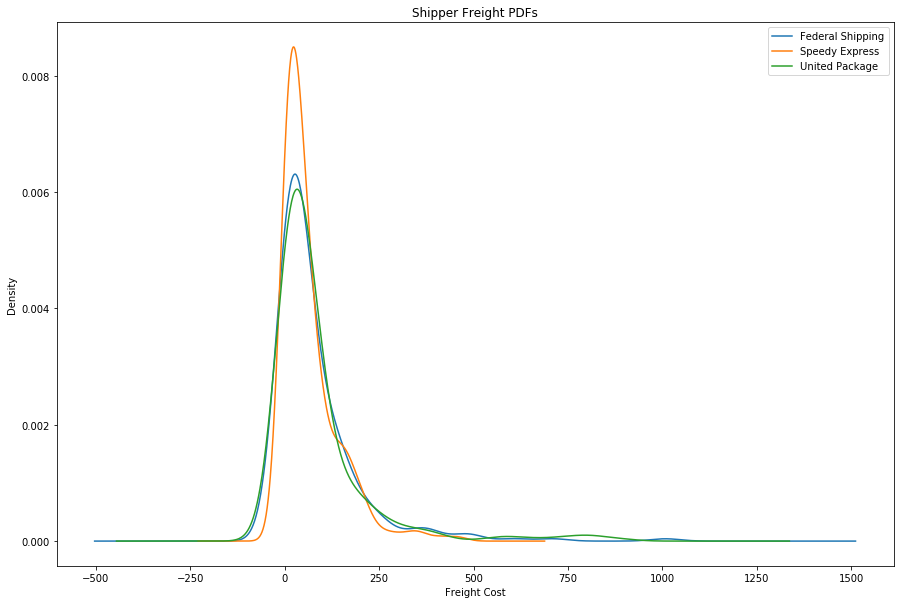

In [41]:
# Plotting
plt.figure(figsize=(15, 10))
fed_df.Freight.plot.kde(label='Federal Shipping')
speed_df.Freight.plot.kde(label='Speedy Express')
united_df.Freight.plot.kde(label='United Package')
plt.title('Shipper Freight PDFs')
plt.xlabel('Freight Cost')
plt.legend()
plt.show()

It is difficult to say whether these samples come from different distributions. Let's conduct an ANOVA test with the null hypothesis that 2 or more groups have the same population mean.

In [43]:
from scipy import stats

# ANOVA F-test
F, p = stats.f_oneway(fed_df.Freight, speed_df.Freight, united_df.Freight)

In [44]:
F, p

(2.49781040377206, 0.08288539205995446)

Although the p-value is low, it is not below the 0.05 threshold. However, this test makes some assumptions:
- The samples are independent
- Each sample is from a normally distributed population
- The population standard deviations are equal

We see using our groupby above that each standard deviation is quite different. Additionally, these distributions are most likely not normally distributed. Therefore, we need to do some further analysis.

We see using our describe function that Speedy Express has quite a lower mean than the other two shippers. Let's compare this population mean with individual t-tests against the other distributions. We have that
Null Hypothesis ($H_0$):

$$\mu_A = \mu_B$$

Alternative Hypothesis ($H_1$):

$$\mu_A < \mu_B$$

where A represents speedy express and B represents the other two distributers.

In [55]:
# T Tests for Speedy Express
for data in [fed_df, united_df]:
    results = stats.ttest_ind(speed_df.Freight, data.Freight, equal_var=False)
    alpha = 0.05
    if (results[0] < 0) & (results[1]/2 < alpha):
        print(f"Reject null hypothesis, mean of Speedy Express is less than than mean of {data.CompanyName.iloc[0]}")
    else:
        print(f"Accept null hypothesis ({data.CompanyName.iloc[0]})")

Reject null hypothesis, mean of Speedy Express is less than than mean of Federal Shipping
Reject null hypothesis, mean of Speedy Express is less than than mean of United Package


It seems that Speedy Express has statistically significant lower freight costs than the other two shippers. Let's now compare Federal shipping with the other two.

In [56]:
# T Tests for Federal Shipping
for data in [speed_df, united_df]:
    results = stats.ttest_ind(fed_df.Freight, data.Freight, equal_var=False)
    alpha = 0.05
    if (results[0] < 0) & (results[1]/2 < alpha):
        print(f"Reject null hypothesis, mean of Speedy Express is less than than mean of {data.CompanyName.iloc[0]}")
    else:
        print(f"Accept null hypothesis ({data.CompanyName.iloc[0]})")

Accept null hypothesis (Speedy Express)
Accept null hypothesis (United Package)


Here, we see that Federal shipping does not have statistically lower means than the other two. For speedy shipping this was clear, but for united package this was less clear. A final step could be checking whether United Package has a statistically significant greater mean than the other two.

In [59]:
# T Tests for United Package
for data in [speed_df, fed_df]:
    results = stats.ttest_ind(united_df.Freight, data.Freight, equal_var=False)
    alpha = 0.05
    if (results[0] > 0) & (results[1]/2 < alpha):
        print(f"Reject null hypothesis, mean of Speedy Express is greater than than mean of {data.CompanyName.iloc[0]}")
    else:
        print(f"Accept null hypothesis ({data.CompanyName.iloc[0]})")

Reject null hypothesis, mean of Speedy Express is greater than than mean of Speedy Express
Accept null hypothesis (Federal Shipping)


The results are in - speedy express has statistically significant lower costs than the other two shippers. Of course, it could be that Speedy Express has lower quality shipping than the other two, but this is difficult to gather information on given our data. A final question that could help us determine this is **Do Shippers have a statistically significant impact on Revenue - Freight Cost?** By answering this, we can determine if it is really worth switching entirely to Speedy Express as a sole shipper. We will call our new column 'Profit' although we are not factoring in any other cost but freight. Note that

$$ Profit = Quantity * Unit Price * (1 - Discount) - Freight$$

First, we need to get our data. This will be a join of the first and second queries.

In [67]:
# Query relevant columns
query = """
SELECT 
    od.UnitPrice, 
    od.Quantity, 
    od.Discount, 
    o.Freight,
    s.CompanyName
FROM 
    [Product] p
    JOIN
    [OrderDetail] od
    ON 
    p.Id = od.ProductId
    JOIN 
    [Order] o
    ON
    od.OrderId = o.Id 
    JOIN
    [Shipper] s
    ON
    o.ShipVia = s.Id
"""
df = pd.read_sql_query(query, engine)

In [68]:
df.head(10)

,UnitPrice,Quantity,Discount,Freight,CompanyName
0,14.0,12,0.00,32.38,Federal Shipping
1,9.8,10,0.00,32.38,Federal Shipping
2,34.8,5,0.00,32.38,Federal Shipping
3,18.6,9,0.00,11.61,Speedy Express
4,42.4,40,0.00,11.61,Speedy Express
5,7.7,10,0.00,65.83,United Package
6,42.4,35,0.15,65.83,United Package
7,16.8,15,0.15,65.83,United Package
8,16.8,6,0.05,41.34,Speedy Express
9,15.6,15,0.05,41.34,Speedy Express


In [69]:
# Get Profit column
df['Profit'] = df.UnitPrice*df.Quantity*(1-df.Discount) - df.Freight
df.head()

,UnitPrice,Quantity,Discount,Freight,CompanyName,Profit
0,14.0,12,0.0,32.38,Federal Shipping,135.62
1,9.8,10,0.0,32.38,Federal Shipping,65.62
2,34.8,5,0.0,32.38,Federal Shipping,141.62
3,18.6,9,0.0,11.61,Speedy Express,155.79
4,42.4,40,0.0,11.61,Speedy Express,1684.39


In [71]:
# Get statistics
df.groupby('CompanyName').Profit.describe()

,count,mean,std,min,25%,50%,75%,max
CompanyName,,,,,,,,
Federal Shipping,645.0,496.062524,948.021085,-570.14,94.760,261.890,574.5200,10469.71
Speedy Express,646.0,459.053851,787.459816,-303.88,88.365,273.950,565.7175,14671.36
United Package,864.0,511.548407,996.161872,-504.26,86.915,255.045,559.8725,15616.63


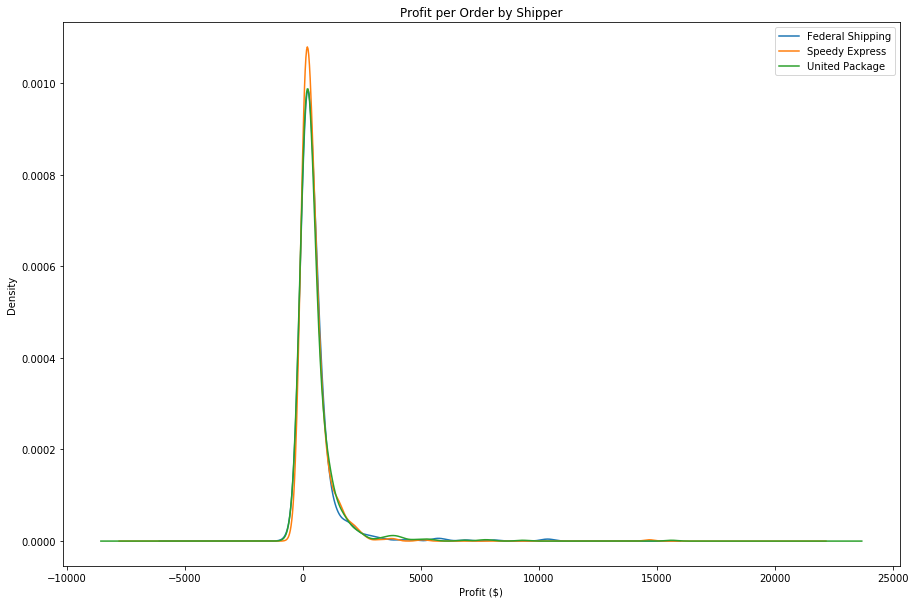

In [76]:
df.groupby('CompanyName').Profit.plot.kde(figsize=(15, 10))
plt.legend()
plt.title('Profit per Order by Shipper')
plt.xlabel('Profit ($)')
plt.show()

These distributions are pretty tight. Let's conduct one-vs-all t-tests similar to before. However, this time we will consider only two tail tests - that is:
Null Hypothesis ($H_0$):

$$\mu_A = \mu_B$$

Alternative Hypothesis ($H_1$):

$$\mu_A \neq \mu_B$$

where A represents one shipper and B represents the other two shippers.

In [85]:
# Get unique shippers
shippers = list(df.CompanyName.unique())
tot_results = {}
alpha = 0.05

# Conduct t-tests
for shipper in shippers:
    for s in [x for x in shippers if x != shipper]:
        results = stats.ttest_ind(df.loc[df.CompanyName == shipper].Profit,
                                  df.loc[df.CompanyName == s].Profit, 
                                  equal_var=False)
        if (results[1] < alpha):
            print(f"Reject null hypothesis, mean of {shipper} is different than than mean of {s}")
        else:
            print(f"Accept null hypothesis ({shipper} vs. {s})")
        tot_results[f"{shipper} vs. {s}"] = results

Accept null hypothesis (Federal Shipping vs. Speedy Express)
Accept null hypothesis (Federal Shipping vs. United Package)
Accept null hypothesis (Speedy Express vs. Federal Shipping)
Accept null hypothesis (Speedy Express vs. United Package)
Accept null hypothesis (United Package vs. Federal Shipping)
Accept null hypothesis (United Package vs. Speedy Express)


In [86]:
# View each result
pprint(tot_results)

{'Federal Shipping vs. Speedy Express': Ttest_indResult(statistic=0.7628955449394752, pvalue=0.44567005839346363),
 'Federal Shipping vs. United Package': Ttest_indResult(statistic=-0.3071519065955489, pvalue=0.7587727188742442),
 'Speedy Express vs. Federal Shipping': Ttest_indResult(statistic=-0.7628955449394752, pvalue=0.44567005839346363),
 'Speedy Express vs. United Package': Ttest_indResult(statistic=-1.1432311482072726, pvalue=0.2531246519298286),
 'United Package vs. Federal Shipping': Ttest_indResult(statistic=0.3071519065955489, pvalue=0.7587727188742442),
 'United Package vs. Speedy Express': Ttest_indResult(statistic=1.1432311482072726, pvalue=0.2531246519298286)}


The two distributions with the lowest compared p-values are United Package and Speedy Express. However, these p-values are not significant enough to consider that shipper company has a statistically significant affect on Profit.

These results are interesting since it means that although Speedy Express is statistically significantly less expensive, it does not guarantee that it is a good business decision to completely switch over to them as sole shipping providers. To probe a littler further, let's run the same tests only on orders that resulted in losses (i.e. Profit < 0).

In [91]:
losses = df.loc[df.Profit < 0]
losses.groupby('CompanyName').Profit.describe()

,count,mean,std,min,25%,50%,75%,max
CompanyName,,,,,,,,
Federal Shipping,39.0,-130.624872,144.754861,-570.14,-176.585,-73.15,-41.61,-1.14
Speedy Express,39.0,-55.114872,61.089518,-303.88,-71.335,-34.56,-16.33,-1.37
United Package,65.0,-103.576231,110.941996,-504.26,-132.720,-53.79,-27.97,-0.80


It seems that on orders that resulted in losses, Speedy Express had lower impacts than the other two shippers. Let's compare speedy express with the other two to see if this statistically significant.

In [96]:
# Run t-test on just losses
res = []
for s in [x for x in shippers if x != 'Speedy Express']:
    results = stats.ttest_ind(losses.loc[losses.CompanyName == 'Speedy Express'].Profit,
                              losses.loc[losses.CompanyName == s].Profit, 
                              equal_var=False)
    if (results[0] > 0) & (results[1]/2 < alpha):
        print(f"Reject null hypothesis, mean of {shipper} is greater than than mean of {s}")
    else:
        print(f"Accept null hypothesis ({shipper} vs. {s})")
    res.append(results)

Reject null hypothesis, mean of Federal Shipping is greater than than mean of United Package
Reject null hypothesis, mean of Federal Shipping is greater than than mean of Federal Shipping


In [97]:
res

[Ttest_indResult(statistic=2.8703700976959055, pvalue=0.004990924359206941),
 Ttest_indResult(statistic=3.001319988063583, pvalue=0.0041498793082418205)]

Wow, looks like there is significant evidence that Speedy Express results in smaller overall losses. Again, keep in mind that when it comes to profit as a whole, we cannot make a significant distinction, but this result is nonethless interesting and thought-provoking.

# Conclusion

We learned some valuable business practice in this lesson. While it is important to check many different metrics for statistical significant, we must make sure to tie it back to financial reasons. This is because business decisions are ultimately dependent on whether or not the decision is likely to increase revenue or decrease cost.

In our case, we found two interesting statistically significant conclusions
- Discounts have a significant effect on the number of items customers order (larger)
- Speedy Express has statistically significant lower shipping costs than both United Package and Federal Shipping

However, when we took a look at how these results affect revenue, we found that
- Discounts do not have a statistically significant affect on revenue per order
- Different shippers do not have a statistically significant affect on "Profit" (Revenue - Freight Cost)

But, upon probing our second above result further, we found that
- On orders that resulted in losses, Speedy Express had statistically less impact than the other two shippers.